# Plots

In [5]:
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import glob
import sys
import torch
# def load_data(path):


In [6]:
solver_path = Path("../solver/tsp")
solver_files = glob.glob(str(solver_path / "*tsp*.pkl"), recursive=True)


# Concorde
def load_solver_file(num_nodes):
    # load pickle of first solver file
    file_ = solver_path / f"tsp_{num_nodes}.pkl"
    with open(file_, 'rb') as f:
        costs = pickle.load(f)
    print("Concorde time for {} nodes: {:.2f}s".format(num_nodes, costs[0]))
    print("Average cost: {:.2f}".format(sum(costs[1])/len(costs[1])))

    return torch.Tensor(costs[1])


def optimality_gap(bk_sol, opt_sol):
    return ((bk_sol - opt_sol) / bk_sol).mean().item() * 100


costs = load_solver_file(50)

Concorde time for 50 nodes: 1904.55s
Average cost: 5.70


In [7]:

# Get all files inside ../results iteratively with .pkl extension
files = glob.glob("../results/**/*.pkl", recursive=True)

# get only tsp50 files
files = [file for file in files if "cvrp50" in file]

print(files)



['../results/eval_methods_pareto/cvrp50/symnco-cvrp50/results.pkl', '../results/eval_methods_pareto/cvrp50/am-cvrp50-sm/results.pkl', '../results/eval_methods_pareto/cvrp50/am-cvrp50/results.pkl', '../results/eval_methods_pareto/cvrp50/pomo-cvrp50/results.pkl', '../results/eval_methods_pareto/cvrp50/am-cvrp50-sm-xl/results.pkl']


In [8]:

# Load first file
with open(files[0], "rb") as f:
    data = pickle.load(f)

In [9]:
# Make plot

experiments = ['greedy', 'augment', 'augment_dihedral_8', 'sampling', 
               'greedy_multistart', 'greedy_multistart_augment_dihedral_8', 
               'greedy_multistart_augment']



data.keys()

dict_keys(['greedy', 'augment', 'augment_dihedral_8', 'sampling', 'greedy_multistart', 'greedy_multistart_augment_dihedral_8', 'greedy_multistart_augment'])

In [10]:
color_scheme = {
    "greedy": "tab:blue",
    "augment": "tab:orange",
    "augment_dihedral_8": "tab:orange",
    "sampling": "tab:green",
    "greedy_multistart": "tab:red",
    "greedy_multistart_augment": "tab:purple",
    "greedy_multistart_augment_dihedral_8": "tab:purple",
}

# marker shape
marker_scheme = {
    "greedy": "o",
    "augment": "o",
    "augment_dihedral_8": "X",
    "sampling": "o",
    "greedy_multistart": "o",
    "greedy_multistart_augment": "o",
    "greedy_multistart_augment_dihedral_8": "X",
}

label_scheme = {
    "greedy": "Greedy",
    "augment": "Augment",
    "augment_dihedral_8": "Augment",
    "sampling": "Sampling",
    "greedy_multistart": "Multistart",
    "greedy_multistart_augment": "Multistart + Augment",
    "greedy_multistart_augment_dihedral_8": "Multistart + Augment"
}


In [191]:
# Make plot with Latex rcparams
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

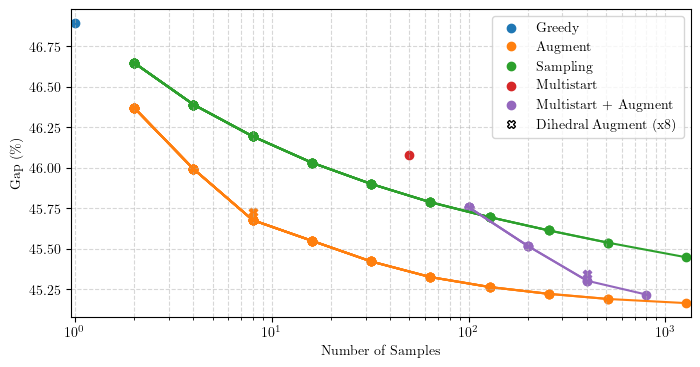

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for experiment in experiments:


    x_values = []
    y_values = []

    for exp in data[experiment]:
        
        costs_model = -exp['rewards']
        gap = optimality_gap(costs_model, costs)

        # If greedy, get optimality gap and plot
        if experiment == 'greedy':
            num_samples = 1

        elif experiment == 'augment' or experiment == 'augment_dihedral_8':
            num_samples = exp['exp_kwargs']['num_augment']

        elif experiment == ('greedy_multistart'):
            num_samples = exp['exp_kwargs']['num_starts']

        elif experiment == 'greedy_multistart_augment' or experiment == 'greedy_multistart_augment_dihedral_8':
            num_samples = exp['exp_kwargs']['num_augment'] * exp['exp_kwargs']['num_starts']
        
        elif experiment == 'sampling':
            num_samples = exp['exp_kwargs']['samples']

        else:
            raise ValueError("Experiment not found")
        x_values.append(num_samples)
        y_values.append(gap)

        # ax.scatter(num_samples, gap, label={experiment}, 
        #            color=color_scheme[experiment], marker=marker_scheme[experiment])
        # Sorting values for proper line plot
        sorted_pairs = sorted(zip(x_values, y_values))
        x_values = [pair[0] for pair in sorted_pairs]
        y_values = [pair[1] for pair in sorted_pairs]

        ax.scatter(x_values, y_values,label=label_scheme[experiment] , 
                color=color_scheme[experiment], marker=marker_scheme[experiment])
        ax.plot(x_values, y_values, color=color_scheme[experiment])

# Make nice grid
ax.grid(True, which="both", ls="--", alpha=0.5)

ax.set_xlim(0.95, None)
ax.set_xlabel("Number of Samples")

# Make legend. If multiple values are found, then remove them
handles, labels = ax.get_legend_handles_labels()
# make line in legend
line_patch = mpatches.FancyBboxPatch((0, 0), 1, 1, fc='white', ec='black', boxstyle='round,pad=0.2')
handles.append(line_patch)
by_label = dict(zip(labels, handles))

new_handle = Line2D([], [], marker='o', linestyle='None', color=color_scheme['augment'])
by_label['Augment'] = new_handle

new_handle = Line2D([], [], marker='X', linestyle='None', 
                    color='black', fillstyle='none')
by_label['Dihedral Augment (x8)'] = new_handle



ax.legend(by_label.values(), by_label.keys(), loc='upper right')

ax.set_ylabel("Gap (\%)")
ax.set_xscale('log')


## Plotting function

In [222]:
from pathlib import Path


def plot_pareto(data, costs, experiments, filename):

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    for experiment in experiments:


        x_values = []
        y_values = []

        for exp in data[experiment]:
            
            costs_model = -exp['rewards']
            gap = optimality_gap(costs_model, costs)

            # If greedy, get optimality gap and plot
            if experiment == 'greedy':
                num_samples = 1

            elif experiment == 'augment' or experiment == 'augment_dihedral_8':
                num_samples = exp['exp_kwargs']['num_augment']

            elif experiment == ('greedy_multistart'):
                num_samples = exp['exp_kwargs']['num_starts']

            elif experiment == 'greedy_multistart_augment' or experiment == 'greedy_multistart_augment_dihedral_8':
                num_samples = exp['exp_kwargs']['num_augment'] * exp['exp_kwargs']['num_starts']
            
            elif experiment == 'sampling':
                num_samples = exp['exp_kwargs']['samples']

            else:
                raise ValueError("Experiment not found")
            x_values.append(num_samples)
            y_values.append(gap)

            # ax.scatter(num_samples, gap, label={experiment}, 
            #            color=color_scheme[experiment], marker=marker_scheme[experiment])
            # Sorting values for proper line plot
            sorted_pairs = sorted(zip(x_values, y_values))
            x_values = [pair[0] for pair in sorted_pairs]
            y_values = [pair[1] for pair in sorted_pairs]

            ax.scatter(x_values, y_values,label=label_scheme[experiment] , 
                    color=color_scheme[experiment], marker=marker_scheme[experiment])
            ax.plot(x_values, y_values, color=color_scheme[experiment])

    # Make nice grid
    ax.grid(True, which="both", ls="--", alpha=0.5)

    ax.set_xlim(0.95, None)
    ax.set_xlabel("Number of Samples")

    # Make legend. If multiple values are found, then remove them
    handles, labels = ax.get_legend_handles_labels()
    # make line in legend
    line_patch = mpatches.FancyBboxPatch((0, 0), 1, 1, fc='white', ec='black', boxstyle='round,pad=0.2')
    handles.append(line_patch)
    by_label = dict(zip(labels, handles))

    new_handle = Line2D([], [], marker='o', linestyle='None', color=color_scheme['augment'])
    by_label['Augment'] = new_handle

    new_handle = Line2D([], [], marker='X', linestyle='None', 
                        color='black', fillstyle='none')
    by_label['Dihedral Augment (x8)'] = new_handle



    ax.legend(by_label.values(), by_label.keys(), loc='upper right')

    ax.set_ylabel("Gap (\%)")
    ax.set_xscale('log')

    # minimum is 0
    # ax.set_ylim(-0.1, None)


    # Save file and create folder if it doesn't exist
    path = filename + ".pdf"
    # create all parent directories if they don't exist
    Path(path).parent.mkdir(parents=True, exist_ok=True)


    plt.savefig(path, bbox_inches='tight')


In [18]:

# Concorde
def load_solver_file_tsp(num_nodes):
    solver_path = Path("../solver/tsp")
    solver_files = glob.glob(str(solver_path / "*tsp*.pkl"), recursive=True)
    # load pickle of first solver file
    file_ = solver_path / f"tsp_{num_nodes}.pkl"
    with open(file_, 'rb') as f:
        costs = pickle.load(f)
    print("Concorde time for {} nodes: {:.2f}s".format(num_nodes, costs[0]))
    print("Average cost: {:.4f}".format(sum(costs[1])/len(costs[1])))

    return torch.Tensor(costs[1])



# HGS
def load_solver_file_vrp(num_nodes):

    solver_path = Path("../solver/vrp")

    dir_ = solver_path / f"{num_nodes}_test_seed_1234"

    solver_files = sorted(glob.glob(str(dir_ / "*.txt")))
    # take the interger of file number and order by it
    solver_files = sorted(solver_files, key=lambda x: int(x.split("/")[-1].split(".")[0]))
    costs = []
    for solver_file in solver_files:
        with open(solver_file, "r") as f:
            # get lines as dict
            lines = f.readlines()
            lines = [line.strip().split() for line in lines]
            lines = {line[0]: line[1:] for line in lines}
            costs.append(float(lines['obj_val:'][0]))
    print("Average cost: {:.4f}".format(sum(costs)/len(costs)))
    return torch.Tensor(costs)

costs = load_solver_file_vrp(50)


Average cost: 10.3661


Concorde time for 50 nodes: 1904.55s
Average cost: 5.70
plots/tsp50/am-tsp50
plots/tsp50/am-sm-tsp50
plots/tsp50/pomo-tsp50
plots/tsp50/am-tsp50-sm-xl
plots/tsp50/symnco-tsp50


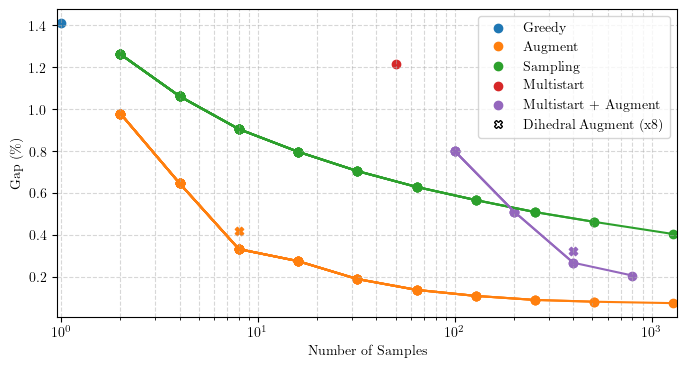

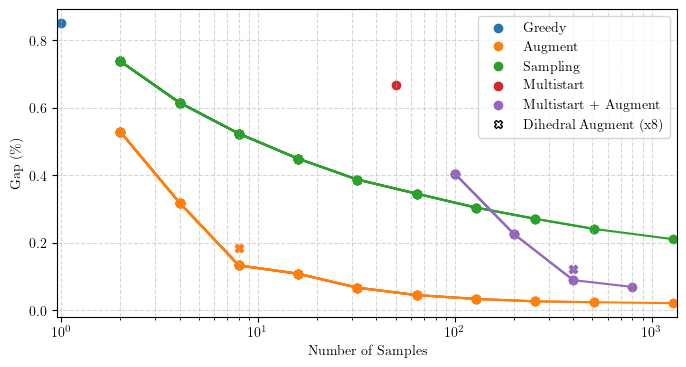

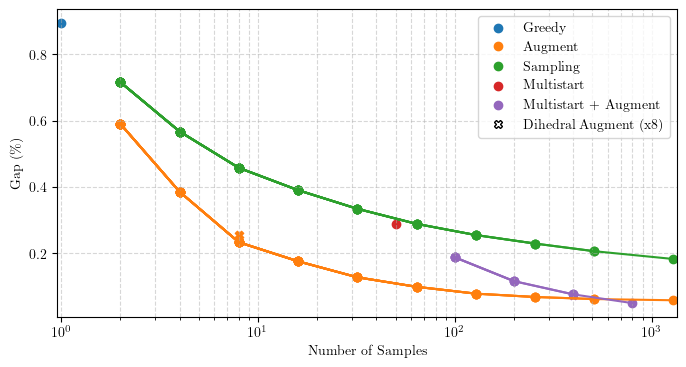

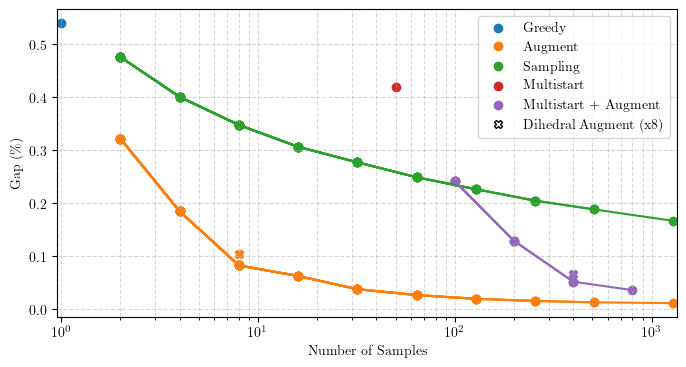

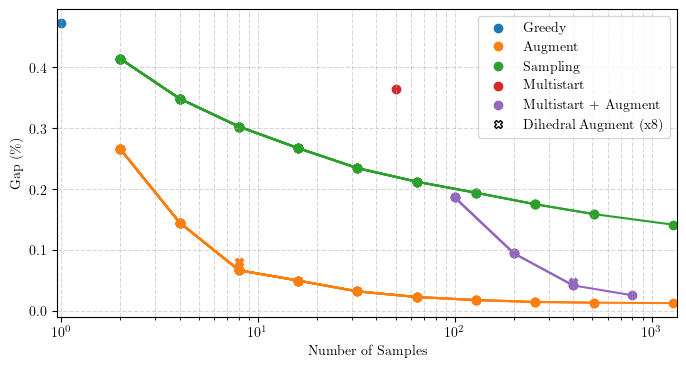

In [234]:

# Get all files inside ../results iteratively with .pkl extension
files = glob.glob("../results/**/*.pkl", recursive=True)

# TSP50
costs = load_solver_file_tsp(50)
files = [file for file in files if "tsp50" in file]

# # TSP20
# costs = load_solver_file_tsp(20)
# files = [file for file in files if "tsp20" in file]


# # CVRP50
# costs = load_solver_file_vrp(50)
# files = [file for file in files if "cvrp50" in file]



# # CVRP20
# costs = load_solver_file_vrp(20)
# files = [file for file in files if "cvrp20" in file]


for f in files:
    data = pickle.load(open(f, "rb"))
    filename = "plots/" + f.split("/")[-3] + "/" + f.split("/")[-2]
    print(filename)
    plot_pareto(data, costs, experiments, filename=filename)


## Save results in table

In [21]:

# CVRP50
costs = load_solver_file_vrp(50)
files = [file for file in files if "cvrp50" in file]
results_name = "cvrp50"


Average cost: 10.3661


In [270]:
from collections import defaultdict
import pandas as pd


# Get all files inside ../results iteratively with .pkl extension
files = glob.glob("../results/**/*.pkl", recursive=True)

# # TSP50
# costs = load_solver_file_tsp(50)
# files = [file for file in files if "tsp50" in file]
# results_name = "tsp50"

# # TSP20
# costs = load_solver_file_tsp(20)
# files = [file for file in files if "tsp20" in file]
# results_name = "tsp20"


# # CVRP50
# costs = load_solver_file_vrp(50)
# files = [file for file in files if "cvrp50" in file]
# results_name = "cvrp50"



# CVRP20
costs = load_solver_file_vrp(20)
files = [file for file in files if "cvrp20" in file]
results_name = "cvrp20"


# Make a CSV table of all results
csv_results = defaultdict(list)


for f in files:
    data = pickle.load(open(f, "rb"))
    filename = "plots/" + f.split("/")[-3] + "/" + f.split("/")[-2]

    model_name = filename.split("/")[-1]

    for experiment in experiments:
        
        for exp in data[experiment]:

            costs_model = -exp['rewards']
            gap = optimality_gap(costs_model, costs)

            costs_model_mean = costs_model.mean().item()

            time = exp['inference_time']

            csv_results['model'].append(model_name)

            # exp name is exp['exp_kwargs'] combo of key and values if any
            kwargs = ""
            for key, value in exp['exp_kwargs'].items():
                kwargs += f"{key}_{value}_"
            csv_results['experiment'].append(experiment)
            csv_results['kwargs'].append(kwargs)
            csv_results['gap'].append(gap)
            csv_results['costs'].append(costs_model_mean)
            csv_results['time'].append(time)
    


# Save as markdown table

df = pd.DataFrame(csv_results)
# df.to_csv("results.csv", index=False)


# # SAve as markdown table
# df.to_markdown("results.md", index=False)


# to html
# df.to_html("results.html", index=False)

# to excel
df.to_excel(f"tables/{results_name}.xlsx", index=False)

Average cost: 6.13
